In [1]:
kde_type = 'vb'

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

if kde_type == 'em':
    import em4kde_torch as kde
elif kde_type == 'vb':
    import vb4kde as kde

Load some data...

In [3]:
from torchvision.datasets import MNIST
testset = MNIST('mnist', train=False, download=True)

mnist_pca = torch.load('mnist_pca_90.pt')
X_reduced = mnist_pca['X_reduced'].float()
X_test = X_reduced[60000:]

Let's take a look at the model for the digit 8

In [4]:
target = 8

In [57]:
model = kde.load_kde('models/kde_' + kde_type + '_' + str(target) +'_90.pt')
sigma = torch.inverse(model.nu * model.W) if kde_type == 'vb' else model.sigma
sigma

tensor([[ 0.1274, -0.0028, -0.0365,  ...,  0.0092,  0.0216,  0.0093],
        [-0.0028,  0.1627,  0.0304,  ...,  0.0082, -0.0211,  0.0163],
        [-0.0365,  0.0304,  0.1318,  ..., -0.0211, -0.0137, -0.0207],
        ...,
        [ 0.0092,  0.0082, -0.0211,  ...,  0.4798, -0.1220, -0.0164],
        [ 0.0216, -0.0211, -0.0136,  ..., -0.1220,  0.2651, -0.0229],
        [ 0.0093,  0.0163, -0.0207,  ..., -0.0164, -0.0229,  0.2555]])

In [58]:
(testset.targets == target).sum()

tensor(974)

In [59]:
def plot_digits(data, num_rows):
    plt.figure(figsize=(2 * len(data) / num_rows, 2 * num_rows))
    plt.tight_layout()
    
    for i, d in enumerate(data):
        
        plt.subplot(num_rows, len(data) / num_rows, i+1)
        plt.imshow(d, cmap='gray', interpolation='none')
        plt.xticks([])
        plt.yticks([])
    
    plt.show()

Let's compare the top 10 highest density observations in the test set with the 10 lowest density ones

In [60]:
X_reduced_target = X_reduced[60000:][testset.targets == target]
X_target = testset.data[testset.targets == target]

log_dens = model.log_density(X_reduced_target)
sorted_dens, sorted_idx = torch.sort(log_dens, descending=False)

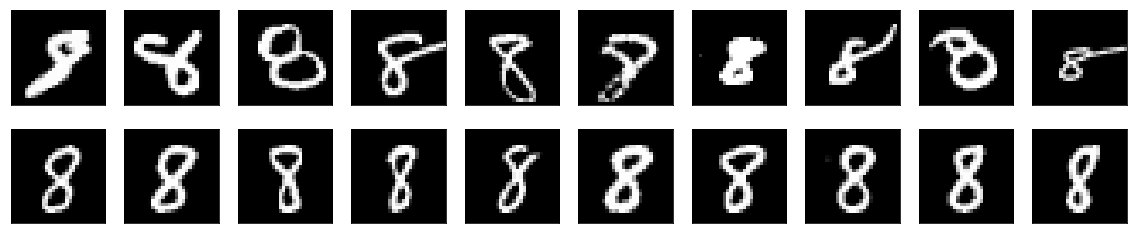

In [61]:
plot_digits(torch.cat((X_target[sorted_idx[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]], 
                       X_target[sorted_idx[[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10]]])), 2)

Sample some examples...

In [92]:
from torch.distributions import MultivariateNormal
n_samples = 30

def sample():
    
    x_train = model.X[np.random.choice(model.X.shape[0])]
    samples = MultivariateNormal(x_train, sigma).sample((1,))
    
    return samples

sc1 = mnist_pca['sc1']
pca = mnist_pca['pca']
sc2 = mnist_pca['sc2']

samples = np.stack([sc1.inverse_transform(pca.inverse_transform(sc2.inverse_transform(sample()))) for _ in range(n_samples)])

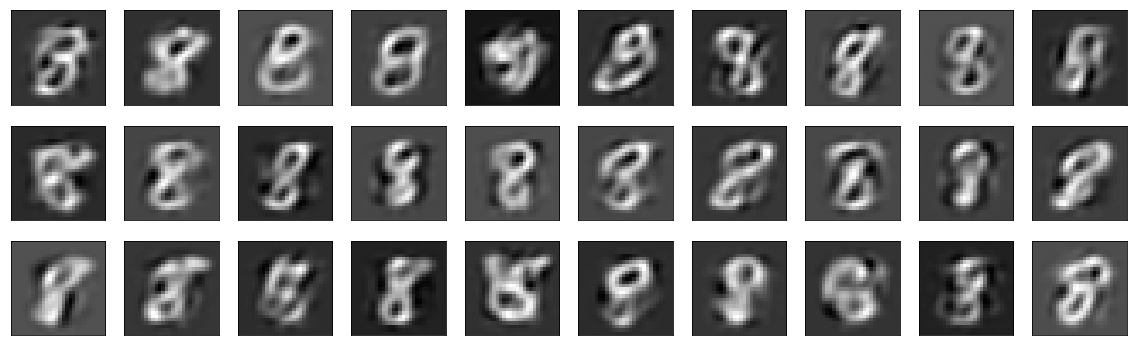

In [93]:
plot_digits(samples.reshape(-1, 28, 28), 3)

We can build a classifier by predicting an observation as belonging to the KDE it has the highest density under

In [10]:
class KDEClassifier:
    def __init__(self, models):
        self.models = models
        
    def predict(self, X):
        
        pred = torch.stack(tuple(model.log_density(X) for model in self.models), dim=0)
        return pred.argmax(dim=0)

In [11]:
models = [kde.load_kde('models/kde_' + kde_type + '_' + str(i) +'.pt') for i in range(10)]
classifier = KDEClassifier(models)

In [12]:
pred = classifier.predict(X_test)

In [13]:
(pred == testset.targets).sum().item() / len(testset)

0.9071

This simple model gives a 90% accuracy on MNIST :O

In [14]:
from sklearn.neighbors import KernelDensity

In [15]:
bandwidths = [0.33, 0.2, 0.73, 0.43, 0.36, 0.41, 0.47, 0.46, 0.36, 0.37]
sklearn_models = [KernelDensity(kernel='gaussian', bandwidth=bw) for bw in bandwidths]

for m, sk_m in zip(models, sklearn_models):
    sk_m.fit(m.X.numpy())

In [16]:
class KDEClassifier:
    def __init__(self, models):
        self.models = models
        
    def predict(self, X):
        
        pred = np.stack(tuple(model.score_samples(X) for model in self.models), axis=0)
        return pred.argmax(axis=0)

In [17]:
classifier = KDEClassifier(sklearn_models)

In [18]:
pred = classifier.predict(X_test.numpy())

In [19]:
(pred == testset.targets.numpy()).sum() / len(testset)

0.2968